<a href="https://colab.research.google.com/github/bashhwu/Automatic-Essay-Scoring/blob/main/Essay_set_2_regression%2BLSTM%2Bval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
clear all

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
embedding_size=100

In [2]:
ls

sample_data/


In [6]:
mypath='/content/drive/MyDrive/AAAAA'

In [10]:
import io
import pandas as pd

df = pd.read_csv(mypath+'/asap_training_data.tsv',sep='\t', encoding='ISO-8859-1')  # both X and y

df_test = pd.read_csv(mypath+'/asap_valid_set.tsv',sep='\t', encoding='ISO-8859-1')  # only X_test
test_score = pd.read_csv(mypath+'/asap_valid_scores.csv')  # only y_test


df.shape

(12976, 28)

In [11]:
df_test[df_test['essay_set']==2]

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
589,4778,2,"Do u believe there are books, music, magizines...",6578,6579.0
590,4779,2,I strongly believe that there are some materia...,6580,6581.0
591,4780,2,"Do you think that certain books, movies, magaz...",6582,6583.0
592,4781,2,Censorship in libraries should definetly be al...,6584,6585.0
593,4782,2,Many books are helpful as you @MONTH1 know by ...,6586,6587.0
...,...,...,...,...,...
1184,5373,2,It is my opinion that content in libraries sho...,7768,7769.0
1185,5374,2,Libraries have been open to the public for yea...,7770,7771.0
1186,5375,2,A library is a place of information and wisdom...,7772,7773.0
1187,5376,2,"I believe that certain materials, such as book...",7774,7775.0


In [12]:
X_test=df_test[df_test['essay_set']==2]['essay']

In [13]:
X_test.shape

(600,)

In [14]:
y_test=test_score[test_score['essay_set']==2][test_score['prediction_id']%2==0]['predicted_score']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [15]:
test_score[test_score['essay_set']==2].head(3)

,prediction_id,essay_id,essay_set,essay_weight,predicted_score
589,6578,4778,2,0.5,4
590,6579,4778,2,0.5,3
591,6580,4779,2,0.5,4


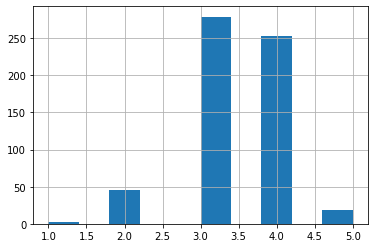

In [16]:
y_test.hist()

In [17]:
X = df.dropna(axis=1) 
X =X[X['essay_set']==2]
X = X.drop(columns=['essay_id','essay_set','rater1_domain1', 'rater2_domain1'])

y = X['domain1_score'] # Only domain1_score is considered
X=X['essay']

In [18]:
X.shape

(1800,)

(array([  1.,  14.,  54., 144., 241., 262., 172.,  85.,  19.,   8.]),
 array([-0.35126234, -0.2838221 , -0.21638185, -0.14894161, -0.08150136,
        -0.01406112,  0.05337913,  0.12081937,  0.18825962,  0.25569986,
         0.32314011]),
 <a list of 10 Patch objects>)

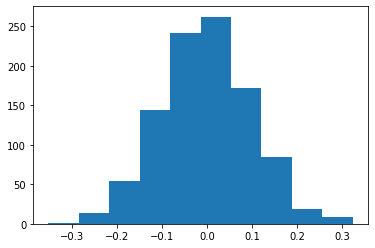

In [19]:
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 0, 0.1 # mean and standard deviation
sig = np.random.normal(mu, sigma, 1000)
plt.hist(sig)

In [ ]:
X.shape, y.shape

((1800,), (1800,))

In [26]:
X.head()

1783    Certain materials being removed from libraries...
1784    Write a persuasive essay to a newspaper reflec...
1785    Do you think that libraries should remove cert...
1786    In @DATE1's world, there are many things found...
1787    In life you have the 'offensive things'. The l...
Name: essay, dtype: object

In [27]:
X_total=pd.concat([X, X_test], sort=False)

In [28]:
y

1783    4
1784    1
1785    2
1786    4
1787    4
       ..
3578    3
3579    3
3580    2
3581    3
3582    3
Name: domain1_score, Length: 1800, dtype: int64

In [29]:
# Add noise to the scores
y=y+np.random.normal(0.0, 0.1, y.shape)
y_test=y_test+np.random.normal(0.0, 0.1, y_test.shape)

In [30]:
y

1783    3.672644
1784    1.005438
1785    2.164895
1786    4.113927
1787    3.951564
          ...   
3578    2.882253
3579    2.944582
3580    1.899342
3581    2.986966
3582    3.093041
Name: domain1_score, Length: 1800, dtype: float64

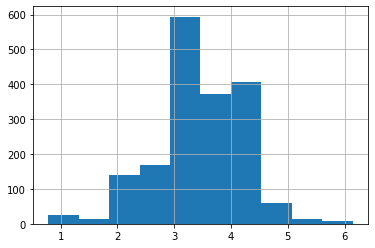

In [31]:
y.hist()

In [32]:
X_total.shape, X.shape, X_test.shape

((2400,), (1800,), (600,))

### Load the Glove embedding vectors

In [33]:
import numpy as np

# load the whole embedding into memory
embeddings_index = dict()
f = open(mypath+'/glove.6B.'+str(embedding_size)+'d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
mypath+'/glove.6B.'+str(embedding_size)+'d.txt'

'/content/drive/MyDrive/AAAAA/glove.6B.100d.txt'

In [22]:
# embeddings_index is a dictionary with keys representing words
# and values representing embedding vectors
embeddings_index['the'].shape, len(embeddings_index)

((100,), 400000)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer  # instead of one-hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
nltk.download('stopwords')
  
from nltk.corpus import stopwords

def to_sequence(X, remove_stopwords=False): 
    # X is a dataframe
    stops = set(stopwords.words("english"))

    t =Tokenizer(num_words=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
    docs=[]
    for i in range(X.shape[0]):
      ess=X.iloc[i]

      if remove_stopwords:
         ess=[word for word in ess.split() if word not in stops ]
      else:
        ess=ess

      docs.append(ess)  # list of essays (end of for loop)
          
    t.fit_on_texts(docs)  # The entire data
    vocab_size = len(t.word_index) + 1  # calculated based on the whole dataset

    # integer encode the documents
    encoded_docs = t.texts_to_sequences(docs)  # word to index
    l=[]

    max_length=max([len(d) for d in encoded_docs ])

    # pad documents to a max length of max_length words
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='pre')

    return t, padded_docs, max_length, vocab_size

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
t, padded_docs, max_length, vocab_size, =to_sequence(X_total, remove_stopwords=False)

In [35]:
padded_docs.shape, vocab_size, y.shape, max_length

((2400, 1065), 17024, (1800,), 1065)

In [36]:
padded_docs_train=padded_docs[:X.shape[0]]
padded_docs_test=padded_docs[X.shape[0]:]

In [37]:
padded_docs_train.shape, X.shape, padded_docs_test.shape, X_test.shape, y.shape, y_test.shape


((1800, 1065), (1800,), (600, 1065), (600,), (1800,), (600,))

#### Seed the embedding matrix with vectors from a pretrained model

In [38]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embedding_size))
  
for word, i in t.word_index.items():  # i is index 
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [39]:
embedding_matrix  # Embedding matrix before training

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16492   ,  0.17597   ,  0.58032   , ..., -0.30249   ,
        -0.32510999,  0.026373  ]])

In [ ]:
y.unique()

array([4.073551  , 1.09684423, 2.07198367, ..., 1.96920202, 2.94040162,
       3.09552482])

In [40]:
output_neurons=len(y.unique())
output_neurons

1800

In [41]:
# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow import keras
from keras.callbacks import *                                         
from keras import regularizers 
from tensorflow.keras.layers import GlobalAveragePooling1D

def get_model():
    model = Sequential()
    e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length, trainable=True)
    model.add(e)
    #model.add(Flatten()) 

    #model.add(Bidirectional(LSTM(256, dropout=0.2)))
    model.add(Bidirectional(LSTM(256,return_sequences=True, dropout=0.2)))

    #Global Maxpooling
    model.add(GlobalAveragePooling1D())


    model.add(Dense(100, activation='relu')) # 100 50 25
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='relu'))


    model.add(Dense(1))
    
    # compile the model
    opt = keras.optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])



    #Adding callbacks
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)  
    #mc=ModelCheckpoint(mypath+'/regression+dense+best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

    # summarize the model
    print(model.summary())
    return model


In [42]:
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True)

In [43]:
from keras.models import load_model

kappa=[]
count=1
for train_index, test_index in cv.split(padded_docs_train):
    print("\n--------Fold {}--------\n".format(count))
    X_val, X_train, y_val, y_train = padded_docs_train[test_index], padded_docs_train[train_index], y.iloc[test_index], y.iloc[train_index]
    model=get_model()
    print(X_train.shape, y_train.shape,X_val.shape, y_val.shape)
    #model.fit(X_train, y_train, batch_size=64, epochs=100)
    
    #Adding callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)  
    mc=ModelCheckpoint(mypath+'/regression+dense+best_model'+str(count)+'.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

    history = model.fit(X_train, y_train, batch_size=64, epochs=100,validation_data=(X_val,y_val.values),verbose=1,callbacks=[es,mc])
    #loading best model
    model= load_model(mypath+'/regression+dense+best_model'+str(count)+'.h5')
    
    
    y_pred = model.predict(X_val)
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    result = cohen_kappa_score(y_val.values.round(),y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    kappa.append(result)
    count+=1



--------Fold 1--------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1065, 100)         1702400   
_________________________________________________________________
bidirectional (Bidirectional (None, 1065, 512)         731136    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (N

In [44]:
kappa

[0.6871307560451997, 0.6870529327610873, 0.6588857883291563]

In [45]:
np.mean(kappa).round(3)

0.678

In [53]:
#loading best model
from keras.models import load_model
model1= load_model('/content/drive/MyDrive/AAAAA/regression+dense+best_model1.h5')

In [54]:
R=pd.DataFrame(np.zeros((1)), index=['QWK'], columns=['Model1'])

In [55]:
R

,Model1
QWK,0.0


In [56]:
y_pred1 = model1.predict(padded_docs_test).round()
y_pred2 = model2.predict(padded_docs_test).round()
y_pred3 = model3.predict(padded_docs_test).round()
R['Model1']=cohen_kappa_score(y_test.round().values,y_pred1,weights='quadratic').round(3)


In [57]:
R

,Model1
QWK,0.736


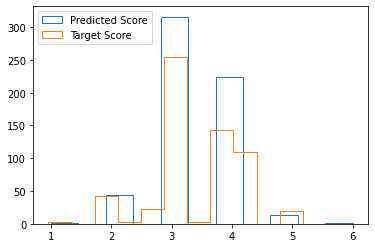

In [51]:
import matplotlib.pyplot as plt
plt.hist(y_pred2,bins=11, histtype='step')
plt.hist(y_test,bins=11, histtype='step')
plt.legend(['Predicted Score', 'Target Score'], loc='upper left')

In [ ]:
https://www.tensorflow.org/text/tutorials/text_classification_rnn#stack_two_or_more_lstm_layers